In [186]:
import pandas as pd
import numpy as np
import random
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_score, recall_score
import matplotlib
import matplotlib.pyplot as plt

In [187]:
df = pd.read_csv("Dataset.csv")
df = pd.DataFrame(df)
df = df.drop(columns='Info')

df.head()

,No.,Time,Time since previous frame,Source,Destination,Time to Live,Data length,Frame length,Protocol
0,1,0.000000,0.000000,151.30.61.46,192.168.1.3,53,825,867,UDP
1,2,0.000323,0.000323,151.30.61.46,192.168.1.3,53,824,866,UDP
2,3,0.000703,0.000380,151.30.61.46,192.168.1.3,53,1014,1056,UDP
3,4,0.001089,0.000386,151.30.61.46,192.168.1.3,53,1014,1056,UDP
4,5,0.001091,0.000002,151.30.61.46,192.168.1.3,53,1014,1056,UDP


In [188]:
df['Time'] = pd.to_datetime(df['Time'], unit='s')

df = df.drop(columns=['No.'])

In order to create a useful dataset to fit the models, we have to create samples by windowing the raw dataset with window of T seconds.
While aggregating every T seconds, we compute some useful features.

In [189]:
dst_address = "151.30.61.46"
time_window = "0.5S"

In [190]:
df_complete = df.resample(time_window, on='Time').agg(
    {'Time to Live' : np.mean, 'Time since previous frame' : np.mean,
     'Data length' : np.mean, 'Frame length' : np.mean})

In [191]:
df_complete.head()

,Time to Live,Time since previous frame,Data length,Frame length
Time,,,,
1970-01-01 00:00:00.000,58.238095,0.001299,877.436508,919.436508
1970-01-01 00:00:00.500,58.558824,0.001325,856.040107,898.040107
1970-01-01 00:00:01.000,58.614925,0.001436,829.504478,871.504478
1970-01-01 00:00:01.500,58.530055,0.001384,839.967213,881.967213
1970-01-01 00:00:02.000,58.440860,0.001339,840.841398,882.841398


Since we want to compute the rate of inbound and outbound packets, we retrieve two sub-datasets to compute them.
Once computed, the columns are added to the original dataset.

In [192]:
df_inbound = df.loc[df['Source'] == dst_address]
df_outbound = df.loc[df['Destination'] == dst_address]

df_inbound = df_inbound.drop(columns=['Destination'])
df_outbound = df_outbound.drop(columns=['Source'])

In [193]:
df_inbound = df_inbound.resample(time_window, on='Time').agg(
    {'Source' : 'count', 'Time to Live' : np.mean,'Time since previous frame' : np.mean,
     'Data length' : np.mean, 'Frame length' : np.mean})

df_inbound = df_inbound.rename(columns={'Source' : 'Inbound Count'})


df_outbound = df_outbound.resample(time_window, on='Time').agg(
    {'Destination' : 'count', 'Time to Live' : np.mean,'Time since previous frame' : np.mean,
     'Data length' : np.mean, 'Frame length' : np.mean})

df_outbound = df_outbound.rename(columns={'Destination' : 'Outbound Count'})

In [194]:
inbound_count = df_inbound["Inbound Count"]
outbound_count = df_outbound["Outbound Count"]

df_complete = df_complete.join(inbound_count)
df_complete = df_complete.join(outbound_count)

df_complete.reset_index(inplace=True)

df_complete['Time'] = df_complete['Time'].dt.time

In [195]:
df_complete.head()

,Time,Time to Live,Time since previous frame,Data length,Frame length,Inbound Count,Outbound Count
0,00:00:00,58.238095,0.001299,877.436508,919.436508,198,180
1,00:00:00.500000,58.558824,0.001325,856.040107,898.040107,185,189
2,00:00:01,58.614925,0.001436,829.504478,871.504478,164,171
3,00:00:01.500000,58.530055,0.001384,839.967213,881.967213,182,184
4,00:00:02,58.440860,0.001339,840.841398,882.841398,188,184


In [196]:
labels = pd.read_csv("Labels.csv")
labels = pd.DataFrame(labels)

labels.head()

,label
0,1
1,1
2,1
3,1
4,1


In [197]:
df_complete = df_complete.join(labels)

In [198]:
df_complete.head()

,Time,Time to Live,Time since previous frame,Data length,Frame length,Inbound Count,Outbound Count,label
0,00:00:00,58.238095,0.001299,877.436508,919.436508,198,180,1
1,00:00:00.500000,58.558824,0.001325,856.040107,898.040107,185,189,1
2,00:00:01,58.614925,0.001436,829.504478,871.504478,164,171,1
3,00:00:01.500000,58.530055,0.001384,839.967213,881.967213,182,184,1
4,00:00:02,58.440860,0.001339,840.841398,882.841398,188,184,1


In [199]:
df_complete = df_complete.dropna()
df_complete = df_complete.drop(columns='Time')
df_complete = df_complete.drop(columns='Frame length')
df_complete['label'] = df_complete['label'].astype(int)

df_complete

,Time to Live,Time since previous frame,Data length,Inbound Count,Outbound Count,label
0,58.238095,0.001299,877.436508,198,180,1
1,58.558824,0.001325,856.040107,185,189,1
2,58.614925,0.001436,829.504478,164,171,1
3,58.530055,0.001384,839.967213,182,184,1
4,58.440860,0.001339,840.841398,188,184,1
...,...,...,...,...,...,...
1915,58.575342,0.001322,788.991781,180,185,0
1916,58.660819,0.001443,774.435673,166,176,0
1917,58.860119,0.001420,773.125000,157,179,0
1918,58.804665,0.001429,757.463557,162,181,0


In [200]:
# normalizing data

cols = df_complete.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(df_complete)
df_normalized = pd.DataFrame(np_scaled, columns = cols)
df_normalized

,Time to Live,Time since previous frame,Data length,Inbound Count,Outbound Count,label
0,0.553600,0.308476,0.807278,0.500000,0.496599,1.0
1,0.642971,0.338454,0.701094,0.427778,0.557823,1.0
2,0.658604,0.462564,0.569406,0.311111,0.435374,1.0
3,0.634954,0.404452,0.621330,0.411111,0.523810,1.0
4,0.610100,0.353873,0.625668,0.444444,0.523810,1.0
...,...,...,...,...,...,...
1915,0.647574,0.334515,0.368354,0.400000,0.530612,0.0
1916,0.671392,0.470374,0.296117,0.322222,0.469388,0.0
1917,0.726927,0.444722,0.289613,0.272222,0.489796,0.0
1918,0.711475,0.454136,0.211890,0.300000,0.503401,0.0


In [201]:
X = df_complete.loc[:, df_complete.columns != 'label']
Y = df_complete['label']

In [202]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [203]:
model = KNeighborsClassifier(n_neighbors=17)
model.fit(X_train,Y_train)

KNeighborsClassifier(n_neighbors=17)

In [204]:
y_pred_class1 = model.predict(X_test)
expected = Y_test
indexes = expected.index

In [205]:
print("RMS: %r " % np.sqrt(np.mean((y_pred_class1 - expected) ** 2)))

RMS: 0.5204164998665332 


In [206]:
from sklearn import metrics
metrics.accuracy_score(expected, y_pred_class1)

0.7291666666666666

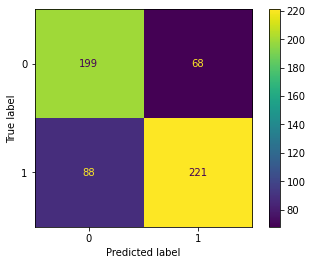

In [207]:
conf_matrix = confusion_matrix(y_true=expected, y_pred=y_pred_class1, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)

disp.plot()

plt.show()

In [208]:
expected = pd.DataFrame(expected)
expected

,label
998,0
1621,0
611,0
514,1
413,0
...,...
706,0
982,0
1289,1
1366,1


In [214]:
y_pred_class1 = pd.DataFrame(y_pred_class1)
y_pred_class1

,0
0,0
1,0
2,0
3,0
4,1
...,...
571,0
572,0
573,1
574,0


In [215]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier()
y_pred_class2 = model.fit(X_train, Y_train).predict(X_test)

metrics.accuracy_score(expected, y_pred_class2)

0.7239583333333334

In [216]:
y_pred_class2 = pd.DataFrame(y_pred_class2)
y_pred_class2

,0
0,0
1,0
2,1
3,1
4,1
...,...
571,0
572,0
573,1
574,0


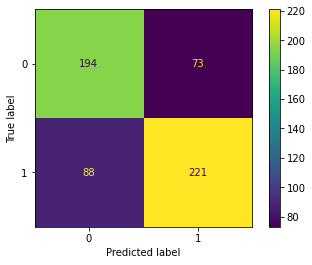

In [211]:
conf_matrix = confusion_matrix(y_true=expected, y_pred=y_pred_class2, labels=model.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=model.classes_)

disp.plot()

plt.show()

In [217]:
expected.to_csv("expected_labels.csv", index=False)
y_pred_class1.to_csv("pred_labels_class1.csv", index=False)
y_pred_class2.to_csv("pred_labels_class2.csv", index=False)